In [25]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint

current_dir = os.path.join(Path().resolve())
# モジュールのあるパスを追加
sys.path.append(str(current_dir) + '/../train')

import model._models as models
import datamodule._datamodules as datamodules
import dataset._datasets as datasets
import route._routes as routes
import mylib.utils as ut
import mylib.config as conf

In [26]:
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
# DF_PATH = os.path.join(ROOT_PATH, "data", "df_test.pickle")
DF_PATH = os.path.join(ROOT_PATH, "data", "df_5s_avg.pickle")
OUTPUT_DIR = os.path.join(ROOT_PATH, "out")
CONFIG_DIR = os.path.join(ROOT_PATH, "config")

In [27]:
log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\2024-09-19-00-28-5s_avg_test")


cp_path = os.path.join(log_dir, "cp/last.ckpt")
config_path = os.path.join(log_dir, "config.yaml")

In [28]:
def plot_route(y, y_hat):
    plt.figure(figsize=(4, 10))
    plt.plot(y[0, :, 0], y[0, :, 1], marker="o")
    plt.plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x")
    plt.xlim(0, 3.5)
    plt.ylim(0, 11)
    plt.show()

In [29]:
def plot_route2(x, y, y_hat):
    # 2つのルートをプロット
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(x[0, :, 3], x[0, :, 4], marker="o")
    ax[1].plot(y[0, :, 0], y[0, :, 1], marker="o", label="true")
    ax[1].plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x", label="pred")
    ax[1].set_xlim(0, 3.5)
    ax[1].set_ylim(0, 11)
    ax[1].legend()
    plt.show()

In [30]:
def plot_test_route(x):
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(x[0, :, 3], x[0, :, 4], marker="o")
    plt.show()

In [31]:
def get_random_noise(mean, std, shape):
    # ランダムノイズを生成
    random_noise = torch.normal(mean=mean, std=std, size=shape)
    # random_noise = torch.empty(x.shape[0], x.shape[1]).uniform_(-0.5, 0.5)
    return random_noise

{'_name': 'RouteDatasetWithRoute', 'n_of_route': 10000}
[{'_name': 'RouteDatasetWithRoute', 'n_of_route': 10000}, {'_name': 'RouteDatasetWithRouteDiff', 'n_of_route': 10000, 'diff_size': 0.13}]
RouteDatasetWithRoute


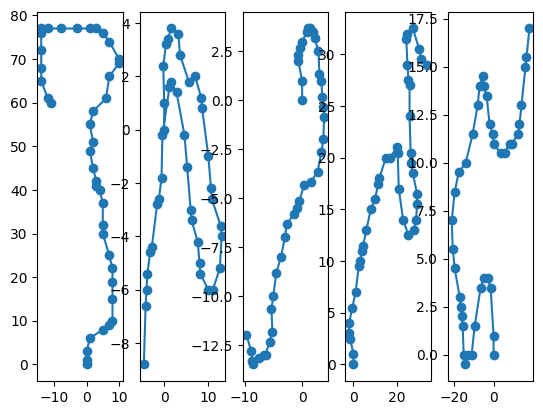

RouteDatasetWithRouteDiff


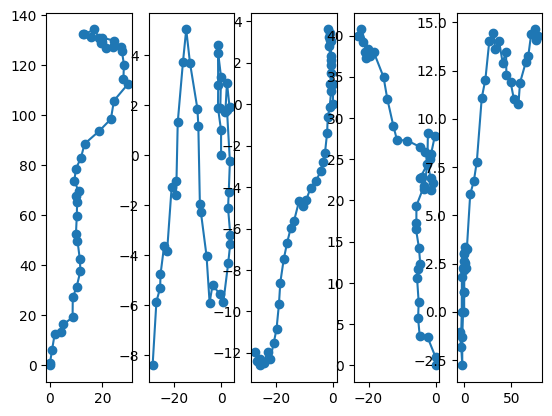

In [35]:

ut.fix_seeds(0)
df = pickle.load(open(DF_PATH, "rb"))
config = conf.from_yaml(config_path)
config = conf.from_yaml(r"C:\Users\hal\Documents\lab\abci\config\config.yaml")

# 各種初期化
model = models.get_model_with_checkpoint(config["model"], cp_path)
route_gen = routes.get_route_generator(config["route"])
dataset = datasets.get_dataset(config["dataset"])
dm = datamodules.get_dm(config["dm"])

dataset.set_route(df, route_gen)
dm.setDataset(dataset)


print(config["dataset"])

datasets_configs = [
    # {
    #     '_name': 'RouteDatasetWithZeros',
    #     'n_of_route': 10000
    # },
    # {
    #     '_name': 'RouteDatasetWithDistance',
    #     'n_of_route': 10000
    # },
    {
        '_name': 'RouteDatasetWithRoute',
        'n_of_route': 10000
    },
    {
        '_name': 'RouteDatasetWithRouteDiff',
        'n_of_route': 10000,
        # 'diff_size': 0
        'diff_size': 0.13
    },
    
]
print(datasets_configs)

dm_config = {
    '_name': 'MyDataModule',
    'batch_size': 64
}

ds_list = [datasets.get_dataset(dc) for dc in datasets_configs]


for j, ds in enumerate(ds_list):
    ut.fix_seeds(0)
    ds.set_route(df, route_gen)
    dm = datamodules.get_dm(dm_config)
    dm.setDataset(ds)

    fig, ax = plt.subplots(1, 5)
    for i in range(5):
        batch = dm.test_dataset[i]

        x, y = batch
        x = x.unsqueeze(0)
        # y = y.unsqueeze(0)

        ax[i].plot(x[0, :, 3], x[0, :, 4], marker="o")
    
    print(datasets_configs[j]["_name"])
    plt.show()




# model.eval()


# loss_list = []
# dist_list = []
# for i in range(10):
#     # batch = dm.train_dataset[i]
#     # batch = dm.val_dataset[i]
#     batch = dm.test_dataset[i]

#     x, y = batch
#     x = x.unsqueeze(0).cuda()
#     y = y.unsqueeze(0).cuda()

#     # mean = 0.0  # 平均
#     # std = 0.381  # 標準偏差
#     # x[:, :, 0] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
#     # x[:, :, 1] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
#     # x[:, :, 2] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()

    
#     y_hat = model(x)

#     # print(y)
#     # print(y_hat)


#     loss = nn.functional.mse_loss(y_hat, y)
#     loss_list.append(loss.item())

#     print(loss.item())

#     x = x.cpu().detach().numpy()
#     y_hat = y_hat.cpu().detach().numpy()
#     y = y.cpu().detach().numpy()
#     plot_route2(x, y, y_hat)
#     # plot_route(y, y_hat)

#     dist_errors = np.linalg.norm(y - y_hat, axis=-1)
#     # print(dist_errors)
#     dist_mean = np.mean(dist_errors)
    
#     dist_list.append(dist_mean)  
#     # print(dist_mean)
    

# plt.plot(loss_list)
# plt.show()

# plt.plot(dist_list)
# plt.show()

# avg = sum(loss_list) / len(loss_list)
# print(avg)
